# An implementation of Inverse parametric PDE, NLLSQ method

In [20]:
import time
from time import perf_counter

import tracemalloc
import gc

import math

import numpy as np
import pandas as pd

from typing import Tuple, List, Callable, Dict, Optional
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class InversePoissonProblem:
    """
    Test case: Inverse Poisson equation
    ∂²u/∂x² + α∂²u/∂y² = f(x,y)
    with true solution: u(x,y) = sin(πx/2)sin(πy/2), α = 1
    """
    def __init__(self):
        self.true_alpha = 1.0
        
    def true_solution(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return torch.sin(np.pi * x / 2) * torch.sin(np.pi * y / 2)
    
    def source_term(self, x: torch.Tensor, y: torch.Tensor, alpha: torch.Tensor) -> torch.Tensor:
        # f(x,y) = -π²/4(1 + α)sin(πx/2)sin(πy/2)
        return -(np.pi**2 / 4) * (1 + alpha) * self.true_solution(x, y)

In [4]:
def generate_training_data(num_points: int, domain_size: float = 1.4) -> Tuple[torch.Tensor, torch.Tensor]:
    """Generate training points and corresponding true solutions"""
    # Create uniform grid of points
    x = torch.linspace(0, domain_size, num_points, device=device)
    y = torch.linspace(0, domain_size, num_points, device=device)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    points = torch.stack([X.flatten(), Y.flatten()], dim=1)
    
    # Generate true solutions
    problem = InversePoissonProblem()
    true_vals = problem.true_solution(points[:, 0], points[:, 1])
    
    return points, true_vals

In [5]:
class NLLSQ_Network(nn.Module):
    """Neural Network for NLLSQ method"""
    def __init__(self, input_dim: int, hidden_dim: int, random_range: float = 1.0):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
        
        # Initialize and freeze hidden layer weights
        nn.init.uniform_(self.hidden.weight, -random_range, random_range)
        nn.init.uniform_(self.hidden.bias, -random_range, random_range)
        self.hidden.weight.requires_grad = False
        self.hidden.bias.requires_grad = False
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = torch.exp(-torch.square(self.hidden(x)))  # Gaussian activation
        return self.output(h)

In [6]:
class VarPro_Network(nn.Module):
    """Neural Network for Variable Projection methods"""
    def __init__(self, input_dim: int, hidden_dim: int, random_range: float = 1.0):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1, bias=False)  # No bias in output layer
        
        # Initialize and freeze hidden layer weights
        nn.init.uniform_(self.hidden.weight, -random_range, random_range)
        nn.init.uniform_(self.hidden.bias, -random_range, random_range)
        self.hidden.weight.requires_grad = False
        self.hidden.bias.requires_grad = False
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = torch.exp(-torch.square(self.hidden(x)))
        return self.output(h)

In [7]:
class LocalRandomNN(nn.Module):
    """
    Local random-weight neural network with fixed hidden layer coefficients
    and trainable output layer weights.
    """
    def __init__(self, 
                 input_dim: int,
                 hidden_sizes: List[int], 
                 output_dim: int,
                 random_range: float = 1.0):
        """
        Args:
            input_dim: Number of input dimensions
            hidden_sizes: List of hidden layer sizes
            output_dim: Number of output dimensions 
            random_range: Range for random weight initialization [-random_range, random_range]
        """
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_sizes = hidden_sizes
        self.output_dim = output_dim
        
        # Build hidden layers with random fixed weights
        self.hidden_layers = nn.ModuleList()
        prev_size = input_dim
        
        for size in hidden_sizes:
            layer = nn.Linear(prev_size, size)
            # Initialize with random weights and freeze them
            nn.init.uniform_(layer.weight, -random_range, random_range)
            nn.init.uniform_(layer.bias, -random_range, random_range)
            layer.weight.requires_grad = False
            layer.bias.requires_grad = False
            self.hidden_layers.append(layer)
            prev_size = size
            
        # Trainable output layer
        self.output_layer = nn.Linear(prev_size, output_dim)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network"""
        for layer in self.hidden_layers:
            x = torch.exp(-torch.square(layer(x)))  # Gaussian activation
        return self.output_layer(x)

In [8]:
class InversePDESolver:
    """
    Solver for inverse PDE problems using local random neural networks.
    """
    def __init__(self,
                 domain_bounds: List[Tuple[float, float]],
                 num_subdomains: List[int],
                 nn_config: dict,
                 pde_loss_fn: Callable,
                 bc_loss_fn: Callable,
                 measurement_loss_fn: Callable):
        """
        Args:
            domain_bounds: List of (min, max) bounds for each dimension
            num_subdomains: Number of subdomains in each dimension
            nn_config: Neural network configuration
            pde_loss_fn: PDE residual loss function
            bc_loss_fn: Boundary condition loss function
            measurement_loss_fn: Measurement data loss function
        """
        self.domain_bounds = domain_bounds
        self.num_subdomains = num_subdomains
        self.dim = len(domain_bounds)
        
        # Create local neural networks for each subdomain
        self.networks = []
        for _ in range(np.prod(num_subdomains)):
            net = LocalRandomNN(
                input_dim=nn_config['input_dim'],
                hidden_sizes=nn_config['hidden_sizes'],
                output_dim=nn_config['output_dim'],
                random_range=nn_config.get('random_range', 1.0)
            )
            self.networks.append(net)
            
        self.pde_loss = pde_loss_fn
        self.bc_loss = bc_loss_fn
        self.measurement_loss = measurement_loss_fn
        
    def get_subdomain_idx(self, points: torch.Tensor) -> torch.Tensor:
        """Map points to their corresponding subdomain indices"""
        idx = torch.zeros(points.shape[0], dtype=torch.long)
        for dim in range(self.dim):
            min_val, max_val = self.domain_bounds[dim]
            dim_idx = torch.floor((points[:,dim] - min_val) / 
                                (max_val - min_val) * self.num_subdomains[dim])
            dim_idx = torch.clamp(dim_idx, 0, self.num_subdomains[dim]-1)
            idx = idx * self.num_subdomains[dim] + dim_idx
        return idx
        
    def forward(self, points: torch.Tensor) -> torch.Tensor:
        """Evaluate the solution at given points"""
        subdomain_idx = self.get_subdomain_idx(points)
        outputs = torch.zeros(points.shape[0], self.networks[0].output_dim)
        
        for i in range(len(self.networks)):
            mask = (subdomain_idx == i)
            if mask.any():
                outputs[mask] = self.networks[i](points[mask])
        return outputs
        
    def train_step(self, 
                   collocation_points: torch.Tensor,
                   measurement_points: torch.Tensor,
                   measurement_values: torch.Tensor,
                   optimizer: torch.optim.Optimizer) -> Tuple[float, float, float]:
        """Perform one training step"""
        optimizer.zero_grad()
        
        # Compute losses
        pde_loss = self.pde_loss(self, collocation_points)
        bc_loss = self.bc_loss(self, collocation_points)
        meas_loss = self.measurement_loss(
            self, measurement_points, measurement_values
        )
        
        # Total loss
        total_loss = pde_loss + bc_loss + meas_loss
        
        # Backpropagation
        total_loss.backward()
        optimizer.step()
        
        return pde_loss.item(), bc_loss.item(), meas_loss.item()

In [9]:
def solve_inverse_pde(solver: InversePDESolver,
                     collocation_points: torch.Tensor,
                     measurement_points: torch.Tensor, 
                     measurement_values: torch.Tensor,
                     num_epochs: int,
                     learning_rate: float = 1e-3) -> Tuple[InversePDESolver, List[float]]:
    """
    Train the solver to find solution to the inverse PDE problem.
    
    Args:
        solver: InversePDESolver instance
        collocation_points: Points for enforcing PDE and boundary conditions
        measurement_points: Points with measurement data
        measurement_values: Measurement data values
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimization
        
    Returns:
        Trained solver and list of losses during training
    """
    # Initialize optimizer (trainable parameters only)
    trainable_params = []
    for net in solver.networks:
        trainable_params.extend(net.output_layer.parameters())
    optimizer = torch.optim.Adam(trainable_params, lr=learning_rate)
    
    losses = []
    for epoch in range(num_epochs):
        pde_loss, bc_loss, meas_loss = solver.train_step(
            collocation_points, measurement_points, measurement_values, optimizer
        )
        total_loss = pde_loss + bc_loss + meas_loss
        losses.append(total_loss)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {total_loss:.6f} "
                  f"(PDE: {pde_loss:.6f}, BC: {bc_loss:.6f}, "
                  f"Measurement: {meas_loss:.6f})")
            
    return solver, losses

In [10]:
def train_nllsq(points: torch.Tensor, 
                values: torch.Tensor, 
                hidden_dim: int = 400, 
                num_epochs: int = 1000) -> Tuple[float, nn.Module]:
    """Train using NLLSQ method"""
    model = NLLSQ_Network(2, hidden_dim).to(device)
    alpha = torch.tensor([1.0], requires_grad=True, device=device)
    optimizer = torch.optim.Adam([{'params': model.output.parameters()},
                                {'params': [alpha]}], lr=1e-3)
    
    problem = InversePoissonProblem()
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Compute PDE residual
        u = model(points)
        ux = torch.autograd.grad(u.sum(), points, create_graph=True)[0][:, 0]
        uy = torch.autograd.grad(u.sum(), points, create_graph=True)[0][:, 1]
        uxx = torch.autograd.grad(ux.sum(), points, create_graph=True)[0][:, 0]
        uyy = torch.autograd.grad(uy.sum(), points, create_graph=True)[0][:, 1]
        
        # PDE residual
        f = problem.source_term(points[:, 0], points[:, 1], alpha)
        residual = uxx + alpha * uyy - f
        
        # Measurement loss
        meas_loss = torch.mean((u - values)**2)
        
        # Total loss
        loss = torch.mean(residual**2) + meas_loss
        
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Alpha: {alpha.item():.6f}")
    
    return alpha.item(), model

In [11]:
def train_varpro(points: torch.Tensor, 
                 values: torch.Tensor, 
                 hidden_dim: int = 400, 
                 num_epochs: int = 1000) -> Tuple[float, nn.Module]:
    """Train using VarPro method"""
    model = VarPro_Network(2, hidden_dim).to(device)
    
    # First phase: train network parameters
    optimizer = torch.optim.Adam(model.output.parameters(), lr=1e-3)
    problem = InversePoissonProblem()
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Forward pass and compute derivatives
        u = model(points)
        ux = torch.autograd.grad(u.sum(), points, create_graph=True)[0][:, 0]
        uy = torch.autograd.grad(u.sum(), points, create_graph=True)[0][:, 1]
        uxx = torch.autograd.grad(ux.sum(), points, create_graph=True)[0][:, 0]
        uyy = torch.autograd.grad(uy.sum(), points, create_graph=True)[0][:, 1]
        
        # Compute optimal alpha using least squares
        A = -uyy
        b = uxx - problem.source_term(points[:, 0], points[:, 1], torch.tensor([1.0], device=device))
        alpha = -(A.T @ b) / (A.T @ A)
        
        # Total loss
        residual = uxx + alpha * uyy - problem.source_term(points[:, 0], points[:, 1], alpha)
        meas_loss = torch.mean((u - values)**2)
        loss = torch.mean(residual**2) + meas_loss
        
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Alpha: {alpha.item():.6f}")
    
    return alpha.item(), model

In [12]:
def compare_methods(num_points: int = 30):
    """Compare NLLSQ and VarPro methods"""
    # Generate training data
    points, values = generate_training_data(num_points)
    points.requires_grad_(True)
    
    # Train using both methods
    print("\nTraining NLLSQ method...")
    start_time = time.time()
    alpha_nllsq, model_nllsq = train_nllsq(points, values)
    nllsq_time = time.time() - start_time
    
    print("\nTraining VarPro method...")
    start_time = time.time()
    alpha_varpro, model_varpro = train_varpro(points, values)
    varpro_time = time.time() - start_time
    
    # Compare results
    print("\nResults Comparison:")
    print(f"True alpha: 1.0")
    print(f"NLLSQ alpha: {alpha_nllsq:.6f} (Time: {nllsq_time:.2f}s)")
    print(f"VarPro alpha: {alpha_varpro:.6f} (Time: {varpro_time:.2f}s)")
    
    # Visualize solutions
    with torch.no_grad():
        x = torch.linspace(0, 1.4, 100, device=device)
        y = torch.linspace(0, 1.4, 100, device=device)
        X, Y = torch.meshgrid(x, y, indexing='ij')
        grid_points = torch.stack([X.flatten(), Y.flatten()], dim=1)
        
        true_sol = InversePoissonProblem().true_solution(grid_points[:, 0], grid_points[:, 1])
        nllsq_sol = model_nllsq(grid_points).squeeze()
        varpro_sol = model_varpro(grid_points).squeeze()
        
        # Plot results
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        for ax, data, title in zip(axes, 
                                 [true_sol, nllsq_sol, varpro_sol],
                                 ['True Solution', 'NLLSQ Solution', 'VarPro Solution']):
            im = ax.contourf(X.cpu(), Y.cpu(), 
                           data.cpu().reshape(100, 100), 
                           levels=20)
            ax.set_title(title)
            plt.colorbar(im, ax=ax)
        
        plt.tight_layout()
        plt.show()

In [13]:
class MethodAnalyzer:
    """
    Analyzer class for comparing inverse PDE solution methods.
    Implements comprehensive metrics and visualization tools.
    """
    def __init__(self, problem, device):
        self.problem = problem
        self.device = device
        self.metrics = {}
        self.convergence_history = {}
        
    def compute_solution_metrics(self, 
                               true_solution: torch.Tensor,
                               computed_solution: torch.Tensor,
                               method_name: str) -> Dict[str, float]:
        """
        Compute comprehensive error metrics for solution quality.
        """
        # Convert to CPU for metric computation
        true_sol = true_solution.cpu().numpy()
        comp_sol = computed_solution.cpu().numpy()
        
        metrics = {
            'mse': mean_squared_error(true_sol, comp_sol),
            'rmse': np.sqrt(mean_squared_error(true_sol, comp_sol)),
            'mae': np.mean(np.abs(true_sol - comp_sol)),
            'r2': r2_score(true_sol, comp_sol),
            'max_error': np.max(np.abs(true_sol - comp_sol)),
            'relative_l2': np.linalg.norm(true_sol - comp_sol) / np.linalg.norm(true_sol)
        }
        
        self.metrics[f"{method_name}_solution"] = metrics
        return metrics
    
    def compute_parameter_metrics(self, 
                                true_param: float,
                                computed_param: float,
                                method_name: str) -> Dict[str, float]:
        """
        Compute error metrics for parameter estimation.
        """
        metrics = {
            'absolute_error': abs(true_param - computed_param),
            'relative_error': abs(true_param - computed_param) / abs(true_param),
            'percentage_error': abs(true_param - computed_param) / abs(true_param) * 100
        }
        
        self.metrics[f"{method_name}_parameter"] = metrics
        return metrics

    def measure_performance(self, 
                          method_func,
                          method_name: str,
                          *args,
                          **kwargs) -> Tuple[float, nn.Module, Dict[str, float]]:
        """
        Measure computational performance metrics for a method.
        """
        # Start memory tracking
        tracemalloc.start()
        start_memory = tracemalloc.get_traced_memory()[0]
        
        # Time measurement
        start_time = perf_counter()
        alpha, model = method_func(*args, **kwargs)
        end_time = perf_counter()
        
        # Memory measurement
        end_memory = tracemalloc.get_traced_memory()[0]
        tracemalloc.stop()
        
        performance_metrics = {
            'execution_time': end_time - start_time,
            'memory_usage': (end_memory - start_memory) / 1024 / 1024,  # Convert to MB
            'convergence_iterations': len(self.convergence_history.get(method_name, [])),
        }
        
        self.metrics[f"{method_name}_performance"] = performance_metrics
        return alpha, model, performance_metrics

    def generate_comparison_report(self) -> pd.DataFrame:
        """
        Generate a comprehensive comparison report of all methods.
        """
        report_data = []
        
        for method in ['nllsq', 'varpro']:
            method_data = {
                'Method': method.upper(),
                # Solution metrics
                'MSE': self.metrics[f"{method}_solution"]['mse'],
                'R2 Score': self.metrics[f"{method}_solution"]['r2'],
                'Relative L2': self.metrics[f"{method}_solution"]['relative_l2'],
                # Parameter metrics
                'Parameter Error (%)': self.metrics[f"{method}_parameter"]['percentage_error'],
                # Performance metrics
                'Execution Time (s)': self.metrics[f"{method}_performance"]['execution_time'],
                'Memory Usage (MB)': self.metrics[f"{method}_performance"]['memory_usage'],
            }
            report_data.append(method_data)
            
        return pd.DataFrame(report_data)

    def plot_comparison_results(self, 
                              true_sol: torch.Tensor,
                              nllsq_sol: torch.Tensor,
                              varpro_sol: torch.Tensor,
                              points: torch.Tensor):
        """
        Generate comprehensive comparison plots.
        """
        fig = plt.figure(figsize=(20, 10))
        gs = fig.add_gridspec(2, 3)
        
        # Solution comparison plots
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax3 = fig.add_subplot(gs[0, 2])
        
        # Error distribution plots
        ax4 = fig.add_subplot(gs[1, 0])
        ax5 = fig.add_subplot(gs[1, 1])
        
        # Convergence plot
        ax6 = fig.add_subplot(gs[1, 2])
        
        # Reshape solutions for plotting
        grid_size = int(np.sqrt(true_sol.shape[0]))
        X = points[:, 0].reshape(grid_size, grid_size).cpu()
        Y = points[:, 1].reshape(grid_size, grid_size).cpu()
        
        true_sol = true_sol.reshape(grid_size, grid_size).cpu()
        nllsq_sol = nllsq_sol.reshape(grid_size, grid_size).cpu()
        varpro_sol = varpro_sol.reshape(grid_size, grid_size).cpu()
        
        # Solution plots
        self._plot_solution(ax1, X, Y, true_sol, "True Solution")
        self._plot_solution(ax2, X, Y, nllsq_sol, "NLLSQ Solution")
        self._plot_solution(ax3, X, Y, varpro_sol, "VarPro Solution")
        
        # Error distribution plots
        self._plot_error_distribution(ax4, true_sol, nllsq_sol, "NLLSQ Error Distribution")
        self._plot_error_distribution(ax5, true_sol, varpro_sol, "VarPro Error Distribution")
        
        # Convergence plot
        self._plot_convergence(ax6)
        
        plt.tight_layout()
        return fig
    
    def _plot_solution(self, ax, X, Y, Z, title):
        """Helper method for plotting solutions"""
        im = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
        plt.colorbar(im, ax=ax)
        ax.set_title(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
    def _plot_error_distribution(self, ax, true_sol, computed_sol, title):
        """Helper method for plotting error distributions"""
        error = (computed_sol - true_sol).flatten()
        sns.histplot(error, ax=ax, kde=True)
        ax.set_title(title)
        ax.set_xlabel('Error')
        ax.set_ylabel('Count')
        
    def _plot_convergence(self, ax):
        """Helper method for plotting convergence history"""
        for method, history in self.convergence_history.items():
            ax.plot(history, label=method)
        ax.set_yscale('log')
        ax.set_title('Convergence History')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Loss (log scale)')
        ax.legend()

In [14]:
def enhanced_compare_methods(num_points: int = 30):
    """
    Enhanced comparison of NLLSQ and VarPro methods with detailed analysis.
    """
    # Initialize analyzer
    problem = InversePoissonProblem()
    analyzer = MethodAnalyzer(problem, device)
    
    # Generate training data
    points, values = generate_training_data(num_points)
    points.requires_grad_(True)
    
    # Train and analyze NLLSQ method
    print("\nAnalyzing NLLSQ method...")
    alpha_nllsq, model_nllsq, nllsq_perf = analyzer.measure_performance(
        train_nllsq, "nllsq", points, values
    )
    
    # Train and analyze VarPro method
    print("\nAnalyzing VarPro method...")
    alpha_varpro, model_varpro, varpro_perf = analyzer.measure_performance(
        train_varpro, "varpro", points, values
    )
    
    # Generate evaluation points
    eval_points = generate_evaluation_grid(100)
    with torch.no_grad():
        true_sol = problem.true_solution(eval_points[:, 0], eval_points[:, 1])
        nllsq_sol = model_nllsq(eval_points).squeeze()
        varpro_sol = model_varpro(eval_points).squeeze()
    
    # Compute solution metrics
    analyzer.compute_solution_metrics(true_sol, nllsq_sol, "nllsq")
    analyzer.compute_solution_metrics(true_sol, varpro_sol, "varpro")
    
    # Compute parameter metrics
    analyzer.compute_parameter_metrics(1.0, alpha_nllsq, "nllsq")
    analyzer.compute_parameter_metrics(1.0, alpha_varpro, "varpro")
    
    # Generate and display comparison report
    report = analyzer.generate_comparison_report()
    print("\nComparison Report:")
    print(report.to_string())
    
    # Plot comparison results
    fig = analyzer.plot_comparison_results(true_sol, nllsq_sol, varpro_sol, eval_points)
    plt.show()
    
    return analyzer, report

def generate_evaluation_grid(size: int) -> torch.Tensor:
    """Generate uniform evaluation grid"""
    x = torch.linspace(0, 1.4, size, device=device)
    y = torch.linspace(0, 1.4, size, device=device)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    return torch.stack([X.flatten(), Y.flatten()], dim=1)

In [15]:
class GPUMemoryManager:
    """
    Manages GPU memory allocation and provides recommendations for optimal point count
    based on available GPU resources.
    """
    def __init__(self, device: torch.device):
        self.device = device
        
    def get_available_memory(self) -> Tuple[float, float]:
        """
        Get total and available GPU memory in GB.
        Returns:
            Tuple of (total_memory, available_memory) in GB
        """
        if self.device.type == "cuda":
            total_memory = torch.cuda.get_device_properties(0).total_memory
            reserved_memory = torch.cuda.memory_reserved(0)
            allocated_memory = torch.cuda.memory_allocated(0)
            available_memory = total_memory - reserved_memory - allocated_memory
            
            return total_memory / (1024**3), available_memory / (1024**3)
        return 0.0, 0.0
    
    def estimate_memory_per_point(self, test_size: int = 100) -> float:
        """
        Estimate memory usage per point by running a small test.
        Returns memory usage in bytes per point.
        """
        if self.device.type != "cuda":
            return 0.0
            
        # Clear existing allocations
        torch.cuda.empty_cache()
        gc.collect()
        
        initial_memory = torch.cuda.memory_allocated(0)
        
        # Create test points
        points = torch.rand((test_size, 2), device=self.device, requires_grad=True)
        values = torch.rand(test_size, device=self.device)
        
        # Estimate memory for network and optimizer
        model = NLLSQ_Network(2, 400).to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        
        # Forward and backward pass to account for gradients
        output = model(points)
        loss = torch.mean((output - values)**2)
        loss.backward()
        
        final_memory = torch.cuda.memory_allocated(0)
        memory_per_point = (final_memory - initial_memory) / test_size
        
        # Cleanup
        del model, optimizer, points, values, output, loss
        torch.cuda.empty_cache()
        gc.collect()
        
        return memory_per_point
    
    def recommend_point_count(self, 
                            safety_factor: float = 0.8,
                            min_points: int = 30,
                            max_points: int = 200) -> int:
        """
        Recommend optimal number of points based on available GPU memory.
        
        Args:
            safety_factor: Fraction of available memory to use (0-1)
            min_points: Minimum number of points to recommend
            max_points: Maximum number of points to recommend
            
        Returns:
            Recommended number of points
        """
        if self.device.type != "cuda":
            return min_points
            
        _, available_memory = self.get_available_memory()
        memory_per_point = self.estimate_memory_per_point()
        
        # Calculate maximum points possible with safety factor
        max_possible_points = int(
            (available_memory * 1024**3 * safety_factor) / memory_per_point
        )
        
        # Round to nearest multiple of 10 for grid points
        recommended_points = min(
            max_points,
            max(
                min_points,
                int(math.floor(math.sqrt(max_possible_points) / 10) * 10)
            )
        )
        
        return recommended_points

In [16]:
def enhanced_compare_methods_with_memory(requested_points: Optional[int] = None) -> Tuple[MethodAnalyzer, pd.DataFrame]:
    """
    Enhanced comparison with GPU memory management.
    
    Args:
        requested_points: Desired number of points (will be adjusted if necessary)
    """
    # Initialize memory manager
    memory_manager = GPUMemoryManager(device)
    
    # Get memory information
    total_memory, available_memory = memory_manager.get_available_memory()
    print(f"\nGPU Memory Status:")
    print(f"Total Memory: {total_memory:.2f} GB")
    print(f"Available Memory: {available_memory:.2f} GB")
    
    # Determine optimal point count
    recommended_points = memory_manager.recommend_point_count()
    
    if requested_points is None:
        num_points = recommended_points
    else:
        if requested_points > recommended_points:
            print(f"\nWarning: Requested point count ({requested_points}) exceeds recommended maximum "
                  f"({recommended_points}) based on available GPU memory.")
            print(f"Adjusting to recommended value to prevent out-of-memory errors.")
            num_points = recommended_points
        else:
            num_points = requested_points
    
    print(f"\nUsing {num_points} points for computation.")
    
    # Memory usage estimate
    estimated_memory = memory_manager.estimate_memory_per_point() * num_points**2 / (1024**3)
    print(f"Estimated GPU memory usage: {estimated_memory:.2f} GB")
    
    # Proceed with comparison using determined point count
    try:
        analyzer, report = enhanced_compare_methods(num_points)
        
        # Add memory usage information to report
        memory_info = pd.DataFrame([{
            'Total GPU Memory (GB)': total_memory,
            'Available GPU Memory (GB)': available_memory,
            'Estimated Usage (GB)': estimated_memory,
            'Points Used': num_points,
            'Recommended Max Points': recommended_points
        }])
        
        print("\nMemory Usage Summary:")
        print(memory_info.to_string())
        
        return analyzer, report
        
    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"\nError: Out of memory error occurred. Try reducing the number of points.")
            print(f"Recommended maximum: {recommended_points}")
        raise e


In [17]:
# compare_methods(num_points=180)

In [18]:
# analyzer, report = enhanced_compare_methods(num_points=120)


GPU Memory Status:
Total Memory: 8.00 GB
Available Memory: 8.00 GB

Using 120 points for computation.
Estimated GPU memory usage: 0.00 GB

Analyzing NLLSQ method...
Epoch 0, Loss: 10.909695, Alpha: 0.999000
Epoch 100, Loss: 0.448095, Alpha: 0.973957
Epoch 200, Loss: 0.285248, Alpha: 0.970996
Epoch 300, Loss: 0.214671, Alpha: 0.968938
Epoch 400, Loss: 0.187306, Alpha: 0.967328
Epoch 500, Loss: 0.174465, Alpha: 0.965832
Epoch 600, Loss: 0.166535, Alpha: 0.964285
Epoch 700, Loss: 0.160715, Alpha: 0.962613
Epoch 800, Loss: 0.156076, Alpha: 0.960805
Epoch 900, Loss: 0.152242, Alpha: 0.958884

Analyzing VarPro method...
Epoch 0, Loss: 233.741058, Alpha: 7.586559


C:\Users\mated\AppData\Local\Temp\ipykernel_11552\4176422693.py:25: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3729.)
  alpha = -(A.T @ b) / (A.T @ A)


Epoch 100, Loss: 0.714129, Alpha: -0.139344
Epoch 200, Loss: 0.522702, Alpha: -0.217342
Epoch 300, Loss: 0.392209, Alpha: -0.289793
Epoch 400, Loss: 0.307607, Alpha: -0.358040
Epoch 500, Loss: 0.251297, Alpha: -0.418377
Epoch 600, Loss: 0.213238, Alpha: -0.468993
Epoch 700, Loss: 0.187408, Alpha: -0.509352
Epoch 800, Loss: 0.169538, Alpha: -0.540080
Epoch 900, Loss: 0.156633, Alpha: -0.562710

Comparison Report:
   Method       MSE  R2 Score  Relative L2  Parameter Error (%)  Execution Time (s)  Memory Usage (MB)
0   NLLSQ  0.053333  0.463539     0.381535             4.309291           42.832354           0.297517
1  VARPRO  0.051993  0.477019     0.376711           157.904351           43.946644           0.165996


C:\Users\mated\AppData\Local\Temp\ipykernel_11552\449231307.py:175: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


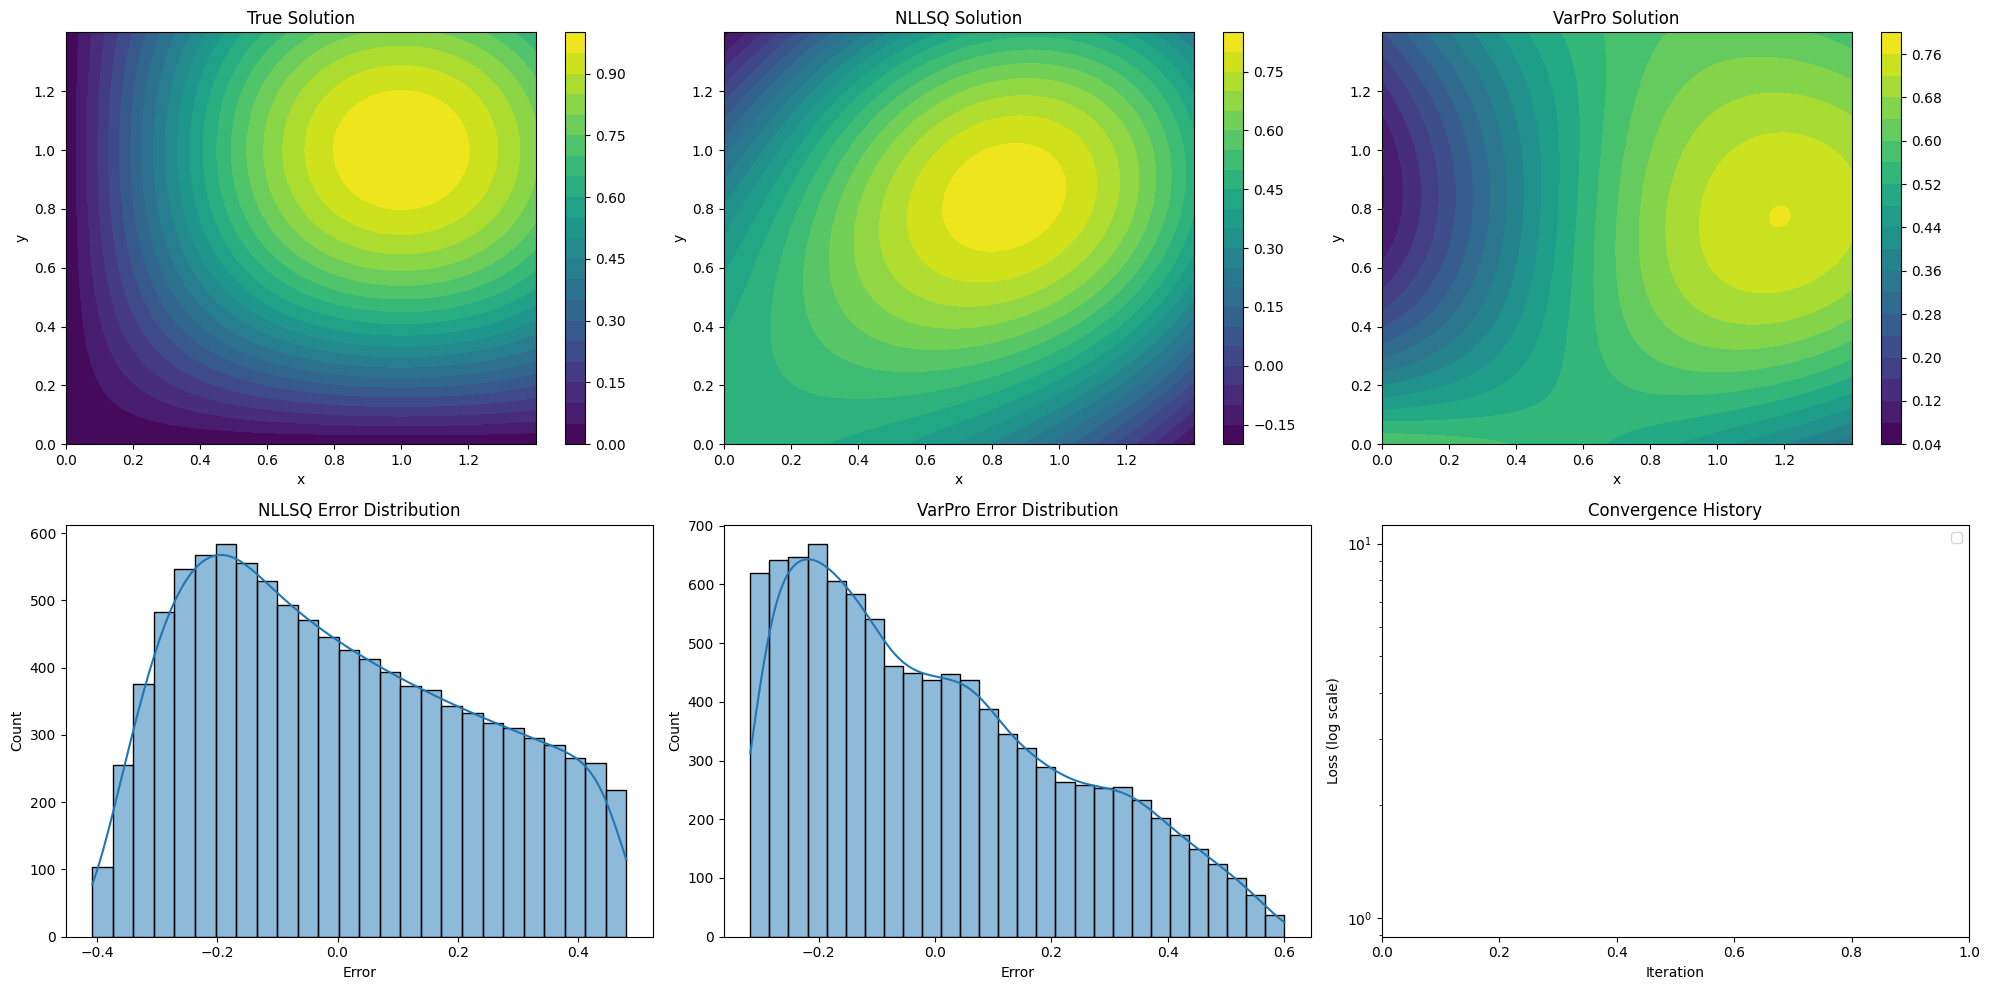


Memory Usage Summary:
   Total GPU Memory (GB)  Available GPU Memory (GB)  Estimated Usage (GB)  Points Used  Recommended Max Points
0               7.999512                   7.999512              0.001923          120                     200


In [19]:
try:
    analyzer, report = enhanced_compare_methods_with_memory(120)
except RuntimeError as e:
    if "out of memory" in str(e):
        print("\nRetrying with recommended point count...")
        analyzer, report = enhanced_compare_methods_with_memory(None)